<a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/model_monitoring/model_monitoring.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Data download and preprocessing

In [1]:
! curl -sS -L -o data.zip "https://www.met.hu/downloads.php?id=12&file=eghajlati_adatsor_1901-2020+&no=Budapest"
! unzip -qq -o data.zip
! rm -rf data.zip ./eves_adatok ./havi_adatok ./szelsosegek oyhw20210514_0000+Budapest.txt

In [2]:
import pandas as pd
import io

df = pd.read_csv("./napi_adatok/BP_d.txt", delimiter=';', encoding='latin1')
df = df[['#datum', 'd_ta']]
df = df.rename(columns={'#datum': 'date', 'd_ta': 'temperature'})
df


,date,temperature
0,1901-01-01,-5.7
1,1901-01-02,-9.3
2,1901-01-03,-9.1
3,1901-01-04,-11.0
4,1901-01-05,-11.1
...,...,...
43825,2020-12-27,0.1
43826,2020-12-28,4.4
43827,2020-12-29,8.8
43828,2020-12-30,7.5


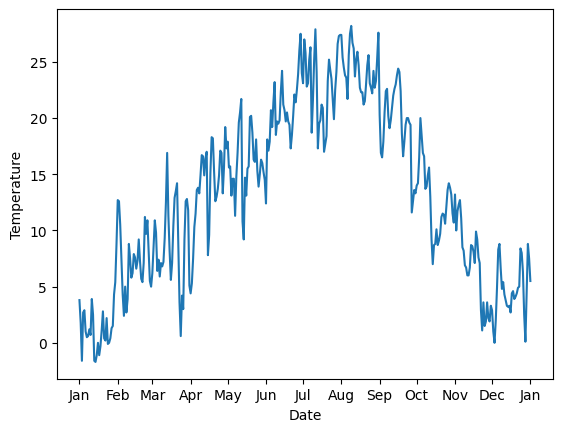

last year mean = 13.234794520547942
mean = 11.328717773214692
std 8.66695774151249
mean = 1.7637930561418868e-16
std = 1.0


,date,temperature
0,1901-01-01,-1.964786
1,1901-01-02,-2.380157
2,1901-01-03,-2.357081
3,1901-01-04,-2.576304
4,1901-01-05,-2.587842
...,...,...
43825,2020-12-27,-1.295578
43826,2020-12-28,-0.799441
43827,2020-12-29,-0.291765
43828,2020-12-30,-0.441760


In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax.plot(df['date'][-366:], df['temperature'][-366:])
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

last_year_mean = df['temperature'][-365:].mean()
print(f"last year mean = {last_year_mean}")

mean = df['temperature'].mean()
print(f"mean = {mean}")
std = df['temperature'].std()
print(f"std {std}")

df['temperature'] = df['temperature'].apply(lambda x: (x - mean) / std)
print(f"mean = {df['temperature'].mean()}")
print(f"std = {df['temperature'].std()}")
df

In [4]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping

# Load the data into a pandas dataframe
df = pd.read_csv("./napi_adatok/BP_d.txt", delimiter=';', encoding='latin1')
df = df[['#datum', 'd_ta']]
df = df.rename(columns={'#datum': 'date', 'd_ta': 'temperature'})

# Preprocess the data
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.dayofyear
mean = df['temperature'].mean()
std = df['temperature'].std()
df['temperature'] = (df['temperature'] - mean) / std

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Reshape the data into the required format for LSTM models
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[(i + time_steps)])
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train = train_data.copy()
X_train, y_train = create_dataset(X_train, train_data['temperature'], time_steps)

X_test = test_data.copy()
X_test, y_test = create_dataset(X_test, test_data['temperature'], time_steps)

# Define the LSTM model architecture
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')


# Train the model on the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])


Epoch 1/50
1973/1973 [==============================] - 3s 1ms/step - loss: 0.2264 - val_loss: 0.0715
Epoch 2/50
1973/1973 [==============================] - 2s 1ms/step - loss: 0.1017 - val_loss: 0.0864
Epoch 3/50
1973/1973 [==============================] - 2s 1ms/step - loss: 0.0976 - val_loss: 0.0709
Epoch 4/50
1973/1973 [==============================] - 2s 1ms/step - loss: 0.0975 - val_loss: 0.0682
Epoch 5/50
1973/1973 [==============================] - 2s 1ms/step - loss: 0.0955 - val_loss: 0.0609
Epoch 6/50
1973/1973 [==============================] - 2s 1ms/step - loss: 0.0923 - val_loss: 0.0884
Epoch 7/50
1973/1973 [==============================] - 2s 1ms/step - loss: 0.0902 - val_loss: 0.0665
Epoch 8/50
1973/1973 [==============================] - 2s 1ms/step - loss: 0.0887 - val_loss: 0.0640
Epoch 9/50
1973/1973 [==============================] - 2s 1ms/step - loss: 0.0867 - val_loss: 0.0632
Epoch 10/50
1973/1973 [==============================] - 2s 1ms/step - loss: 0.084

In [5]:
# Evaluate the model on the testing data
mse = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f' % mse)

# Use the trained model to predict the temperature for the next 3 days
november_12 = [316, 5]
november_13 = [317, 4.5]
november_14 = [318, 12]
last_three_days = [
        november_12,
        november_13,
        november_14
]
X_pred = np.array([last_three_days])
X_pred = (X_pred - mean) / std
november_15 = model.predict(X_pred)
november_15 = (november_15 * std) + mean
november_15 = november_15[0][0]
print('November 15:', november_15)
november_15 = [319, november_15]

X_pred = np.array([[november_13, november_14, november_15]])
X_pred = (X_pred - mean) / std
november_16 = model.predict(X_pred)
november_16 = (november_16 * std) + mean
november_16 = november_16[0][0]
print('November 16:', november_16)
november_16 = [320, november_16]

X_pred = np.array([[november_14, november_15, november_16]])
X_pred = (X_pred - mean) / std
november_17 = model.predict(X_pred)
november_17 = (november_17 * std) + mean
november_17 = november_17[0][0]
print('November 17:', november_17)

MSE: 0.066
1/1 [==============================] - 0s 181ms/step
November 15: 8.92318
1/1 [==============================] - 0s 9ms/step
November 16: 7.028933
1/1 [==============================] - 0s 9ms/step
November 17: 6.3095465
